[View in Colaboratory](https://colab.research.google.com/github/Xinliang-Zhao/Deep_Learning/blob/master/variational_autoencoder.ipynb)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch 0 elbo -544.1594
Epoch 1 elbo -240.48465
Epoch 2 elbo -263.21216
Epoch 3 elbo -271.84766
Epoch 4 elbo -268.86572
Epoch 5 elbo -276.6805
Epoch 6 elbo -283.54434
Epoch 7 elbo -288.4142
Epoch 8 elbo -288.2534
Epoch 9 elbo -297.26114


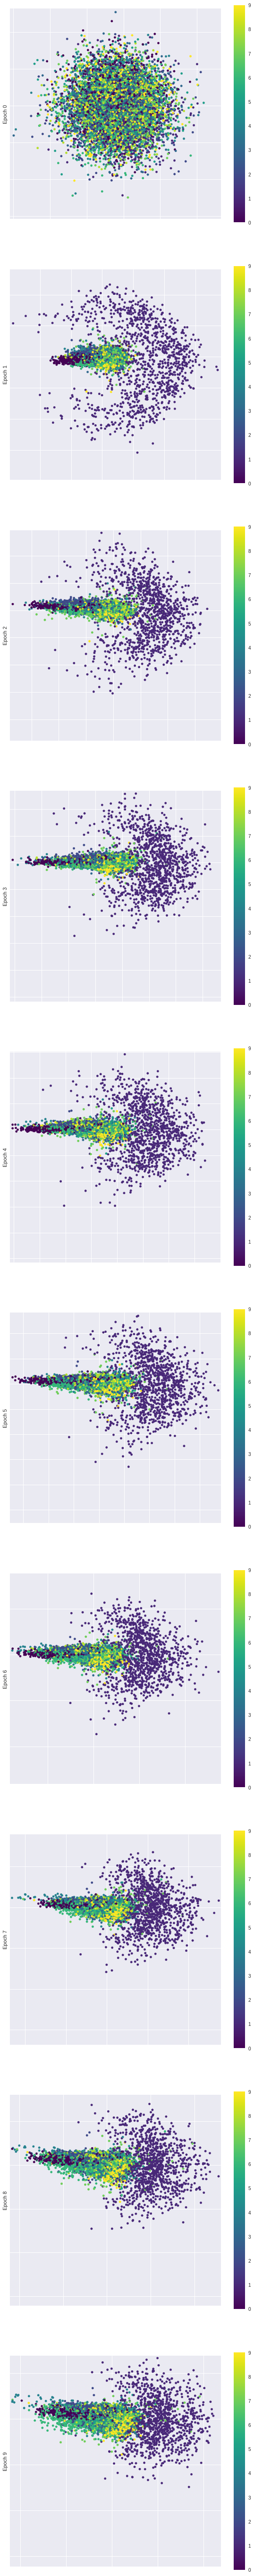

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

tfd = tf.contrib.distributions


def make_encoder(data, code_size):
  x = tf.layers.flatten(data)
  x = tf.layers.dense(x, 200, tf.nn.relu)
  x = tf.layers.dense(x, 200, tf.nn.relu)
  loc = tf.layers.dense(x, code_size)
  scale = tf.layers.dense(x, code_size, tf.nn.softplus)
  return tfd.MultivariateNormalDiag(loc, scale)


def make_prior(code_size):
  loc = tf.zeros(code_size)
  scale = tf.ones(code_size)
  return tfd.MultivariateNormalDiag(loc, scale)


def make_decoder(code, data_shape):
  x = code
  x = tf.layers.dense(x, 200, tf.nn.relu)
  x = tf.layers.dense(x, 200, tf.nn.relu)
  logit = tf.layers.dense(x, np.prod(data_shape))
  logit = tf.reshape(logit, [-1] + data_shape)
  return tfd.Independent(tfd.Bernoulli(logit), 2)


def plot_codes(fig, ax, codes, labels):
  im = ax.scatter(codes[:, 0], codes[:, 1], s=20, c=labels, alpha=1, cmap='viridis')
  fig.colorbar(im, ax=ax)
  ax.set_aspect('equal')
  ax.set_xlim(codes.min() - .1, codes.max() + .1)
  ax.set_ylim(codes.min() - .1, codes.max() + .1)
  ax.tick_params(
      axis='both', which='both', left='off', bottom='off',
      labelleft='off', labelbottom='off')


def plot_samples(ax, samples):
  for index, sample in enumerate(samples):
    ax[index].imshow(sample, cmap='gray')
    ax[index].axis('off')


data = tf.placeholder(tf.float32, [None, 28, 28])

make_encoder = tf.make_template('encoder', make_encoder)
make_decoder = tf.make_template('decoder', make_decoder)

# Define the model.
prior = make_prior(code_size=2)
posterior = make_encoder(data, code_size=2)
code = posterior.sample()

# Define the loss.
likelihood = make_decoder(code, [28, 28]).log_prob(data)
divergence = tfd.kl_divergence(posterior, prior)
elbo = tf.reduce_mean(likelihood - divergence)
optimize = tf.train.AdamOptimizer(0.001).minimize(-elbo)

samples = make_decoder(prior.sample(10), [28, 28]).mean()

mnist = input_data.read_data_sets('MNIST_data/')
train_idx = [idx for (idx, label) in enumerate(mnist.train.labels) if label == 1]
train_images = mnist.train.images[train_idx]
train_labels = mnist.train.labels[train_idx]
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=len(train_idx), reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(100)
train_dataset = train_dataset.repeat()
iterator = train_dataset.make_one_shot_iterator()
train_features, train_labels = iterator.get_next()
fig, ax = plt.subplots(nrows=10, ncols=1, figsize = (10, 100))
init = tf.global_variables_initializer()
with tf.train.MonitoredSession() as sess:
  sess.run(init)
  for epoch in range(10):
    feed = {data: mnist.test.images.reshape([-1, 28, 28])}
    test_elbo = sess.run(elbo, feed_dict = feed)
    test_codes = sess.run(code, feed_dict = feed)
    print('Epoch', epoch, 'elbo', test_elbo)
    ax[epoch].set_ylabel('Epoch {}'.format(epoch))
    plot_codes(fig, ax[epoch], test_codes, mnist.test.labels)
    for _ in range(600):
      feed = {data: sess.run(train_features).reshape([-1, 28, 28])}
      sess.run(optimize, feed_dict = feed)
plt.show()

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data/')
print(mnist.train.labels)
train_idx = [idx for (idx, label) in enumerate(mnist.train.labels) if label == 1]
print(train_idx)
train_images = mnist.train.images[train_idx]
train_labels = mnist.train.labels[train_idx]
print(train_labels)
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
print(train_dataset.output_types)
print(train_dataset.output_shapes)
train_dataset = train_dataset.shuffle(buffer_size=len(train_idx), reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(100)
train_dataset = train_dataset.repeat()
iterator = train_dataset.make_one_shot_iterator()
features, labels = iterator.get_next()
with tf.train.MonitoredSession() as sess:
  for _ in range(600):
    print(sess.run(features))
    print(sess.run(labels))